In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dalex as dx
import scipy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from catboost import CatBoostClassifier
from statsmodels.tools.tools import add_constant
from matplotlib import style

import plotly.io as pio
pio.templates.default = "plotly_dark"
plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['red'])

In [63]:
#loading data
df = pd.read_csv('./BankChurners.csv')
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)

#setting y to 0-1 binary variable
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Existing Customer', 1, inplace=True)
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Attrited Customer', 0, inplace=True)

#defining and splitting variables
X = df.drop(columns=['CLIENTNUM', 'Attrition_Flag'])
y = df['Attrition_Flag']

#used stratified, because of the distribution of y (it's skewed)
idx_train, idx_test = train_test_split(X.index, stratify=y, random_state=999)

X_train, X_test = X.loc[idx_train], X.loc[idx_test]
y_train, y_test = y[idx_train], y[idx_test]

#selecting numerical and categorical columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include='object').columns

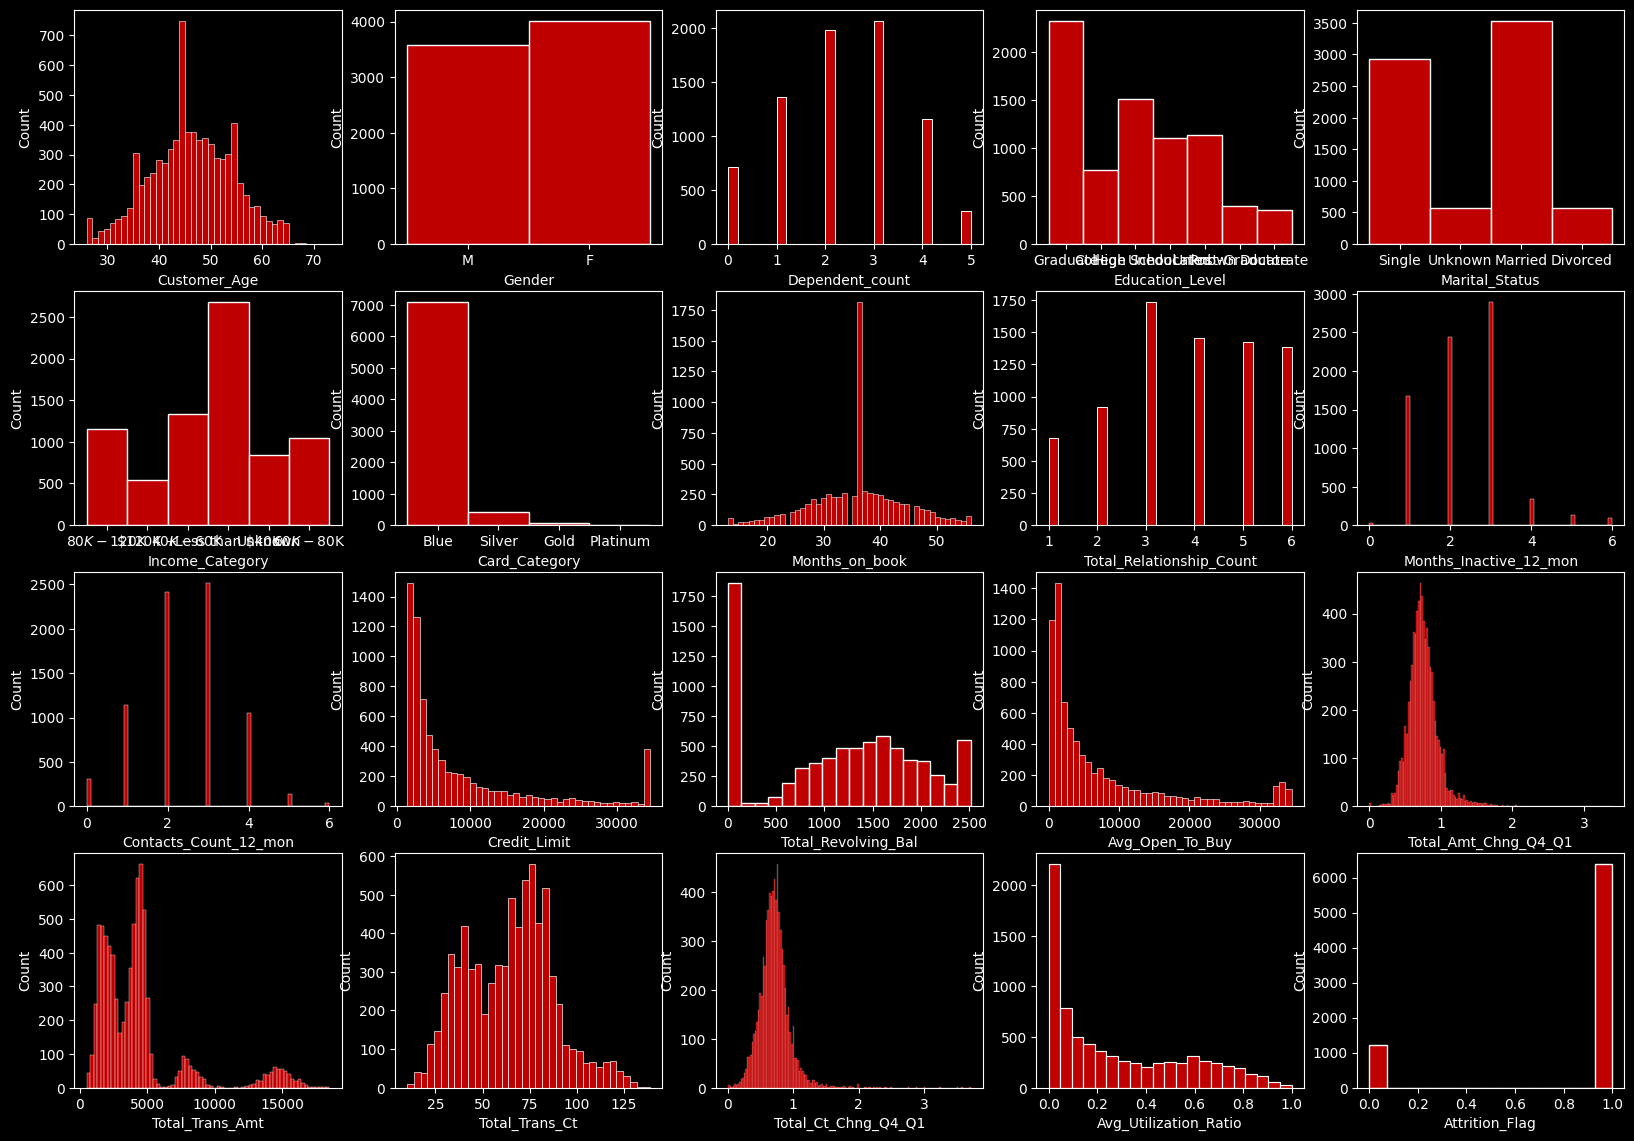

In [64]:
#displaying distribution of the data

plt.figure(figsize=(20,14))
k=1
for i in X_train.columns:
    plt.subplot(4,5,k)
    sns.histplot(X_train[i])
    k+=1
plt.subplot(4,5,k)
sns.histplot(y_train)
plt.show()

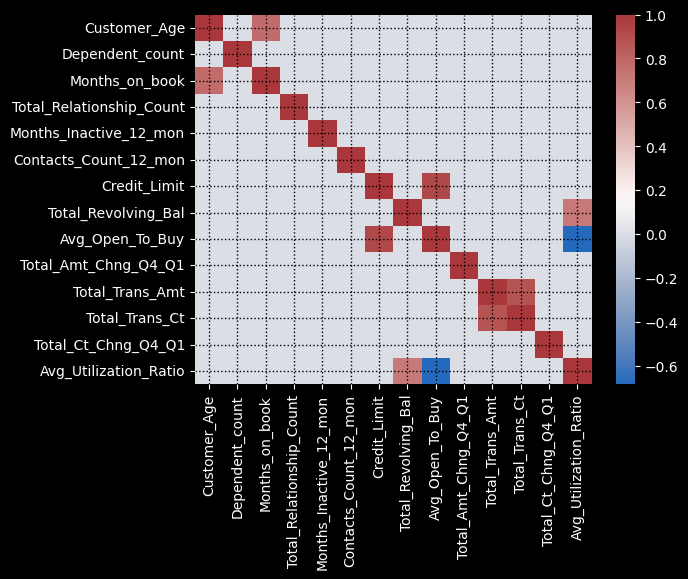

In [96]:
corr_mat = X_train[numerical_columns].corr('spearman', numeric_only=True)
corr_mat[np.abs(corr_mat) < 0.5] = 0
sns.heatmap(corr_mat, cmap="vlag")
plt.grid(lw=1, color='black', linestyle='dotted')
plt.show()

From correlation matrix there are pairs of features which are strongly correlated:  
Months_On_Book and Customer_Age  
Avg_Open_To_Buy and Credit_Limit  
Avg_Utilization_Ratio and Total_Revolving_Bal  
Avg_Utilization_Ratio and Avg_Open_To_Buy  
Total_Trans_Ct and Total_Trans_Amt  
I will consider dropping some of these features later - after seeing their importances. Perhaps dropping one feature of each pair will not cause the model's performance to be worse.

In [66]:
scaler = MinMaxScaler(feature_range=(0,1))

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

encoder = OneHotEncoder(sparse_output=False, handle_unknown="error", dtype=float).set_output(transform="pandas")

one_hot_encoded_train = encoder.fit_transform(X_train[categorical_columns])
one_hot_encoded_test = encoder.transform(X_test[categorical_columns])

X_train.drop(columns=categorical_columns, inplace=True)
X_test.drop(columns=categorical_columns, inplace=True)

X_train = pd.concat([X_train, one_hot_encoded_train], axis=1)
X_test = pd.concat([X_test, one_hot_encoded_test], axis=1)

In [67]:
#building model
model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [68]:
#initializing explainer 

model_exp = dx.Explainer(model, X_test, y_test, label='CBC')

Preparation of a new explainer is initiated

  -> data              : 2532 rows 37 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2532 values
  -> model_class       : catboost.core.CatBoostClassifier (default)
  -> label             : CBC
  -> predict function  : <function yhat_proba_default at 0x00000280CF6C5F30> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 5.35e-05, mean = 0.843, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         :  'residual_function' returns an Error when executed:
'float' object has no attribute 'astype'
  -> model_info        : package catboost

A new explainer has been created!


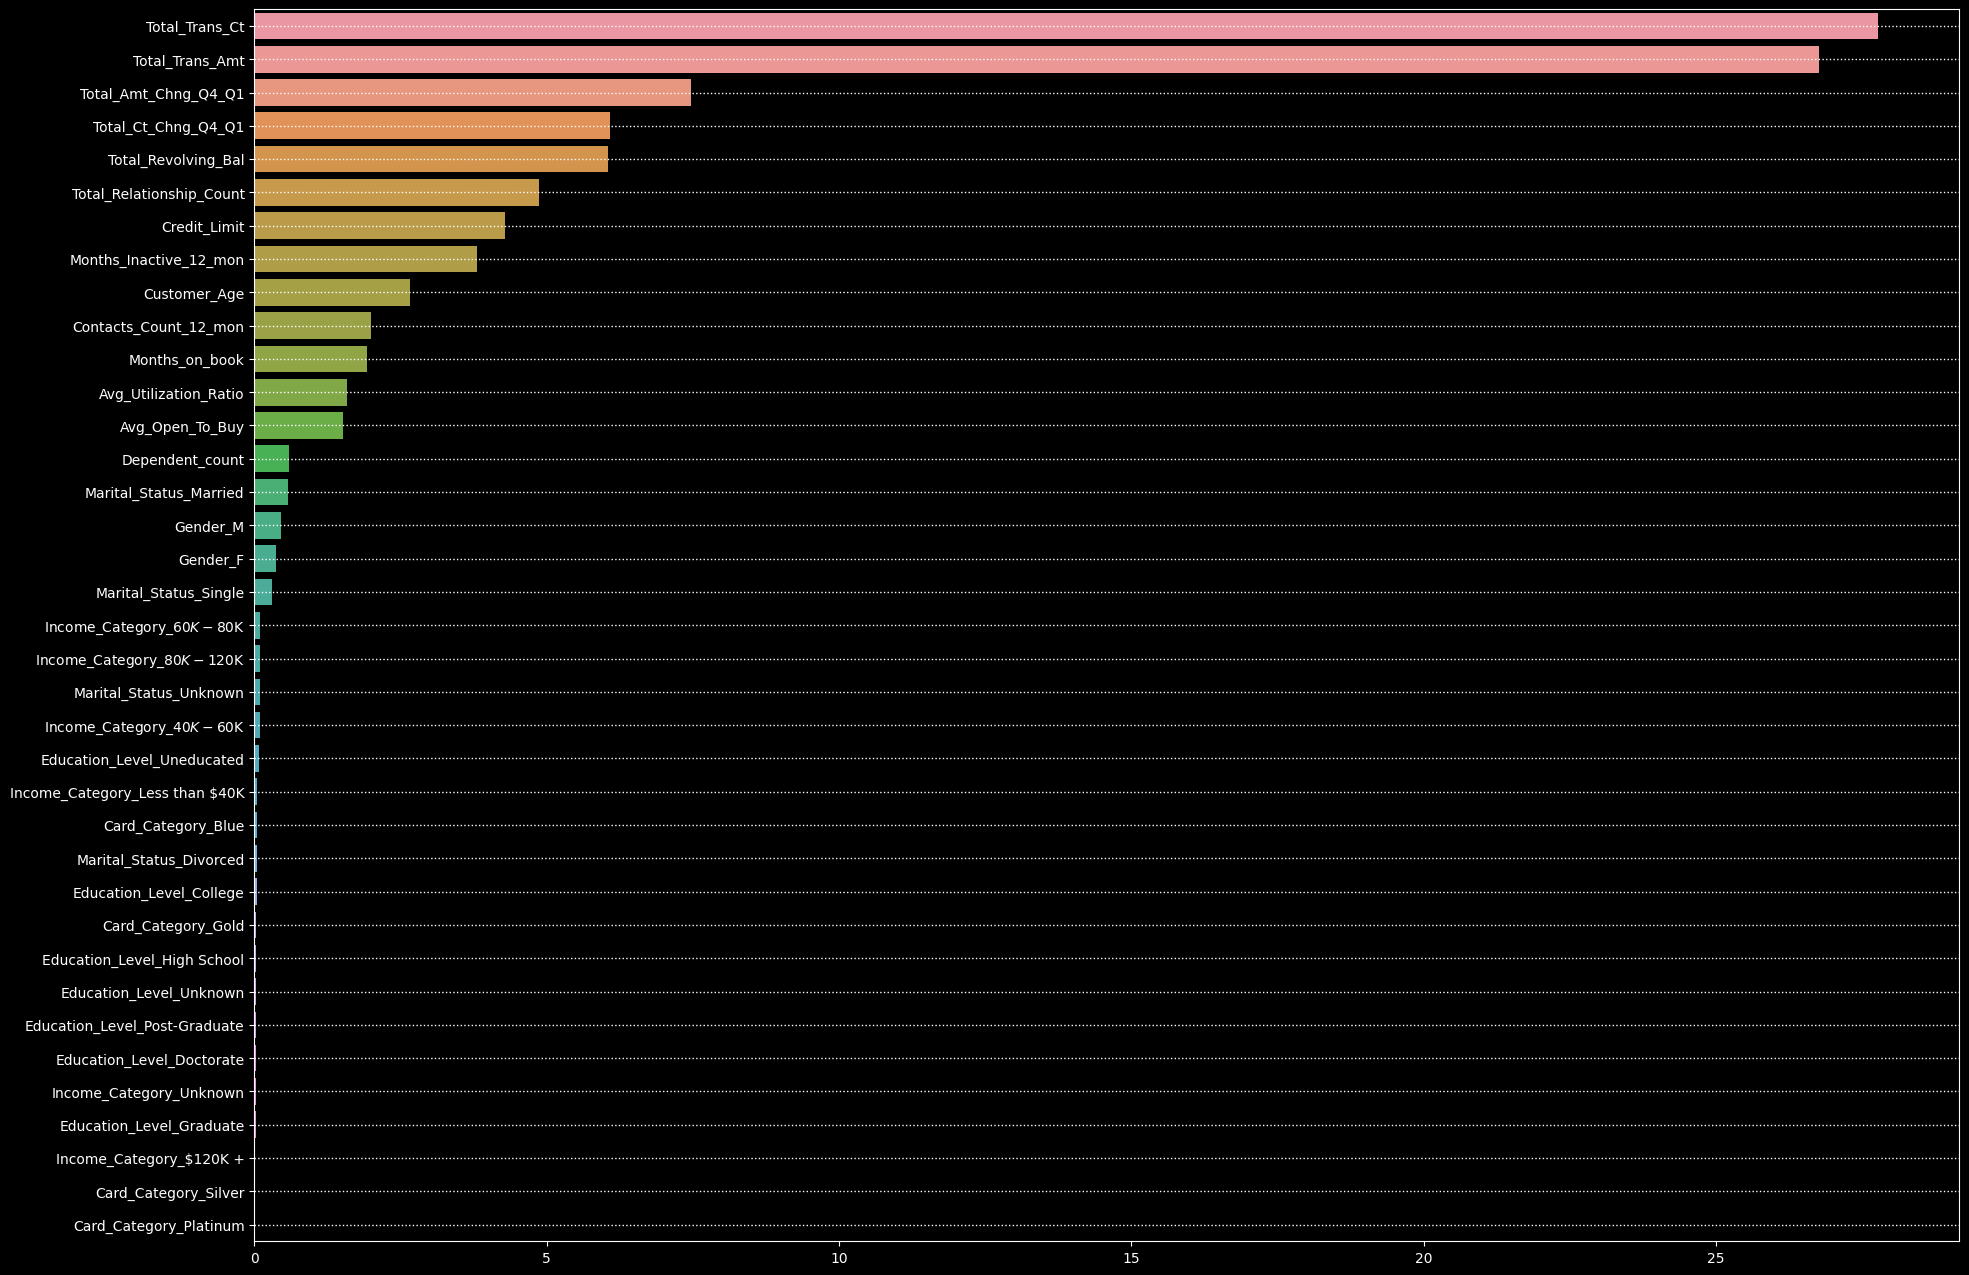

In [69]:
importances = pd.DataFrame(model.feature_importances_.reshape(1,-1), columns=X_train.columns)
plt.figure(figsize=(22,16))
sns.barplot(data=importances.sort_values(by=[0], axis=1, ascending=False), orient='h')
plt.grid(axis='y', color='white', linestyle='dotted', lw=1)
plt.show()

In [97]:
#permutation-based importances
model_exp_importances = model_exp.model_parts()
model_exp_importances.plot(max_vars=None, show=False).update_layout(template='plotly_dark')

Let's drop features which are the least important.  
I set the importance threshhold to 0.2980692275 (so I drop every feature below Marital_Status_Single from the barplot) and check model's performance once again with no extra features.  
Another step will be using only features selected from second importance plot and comparing models.

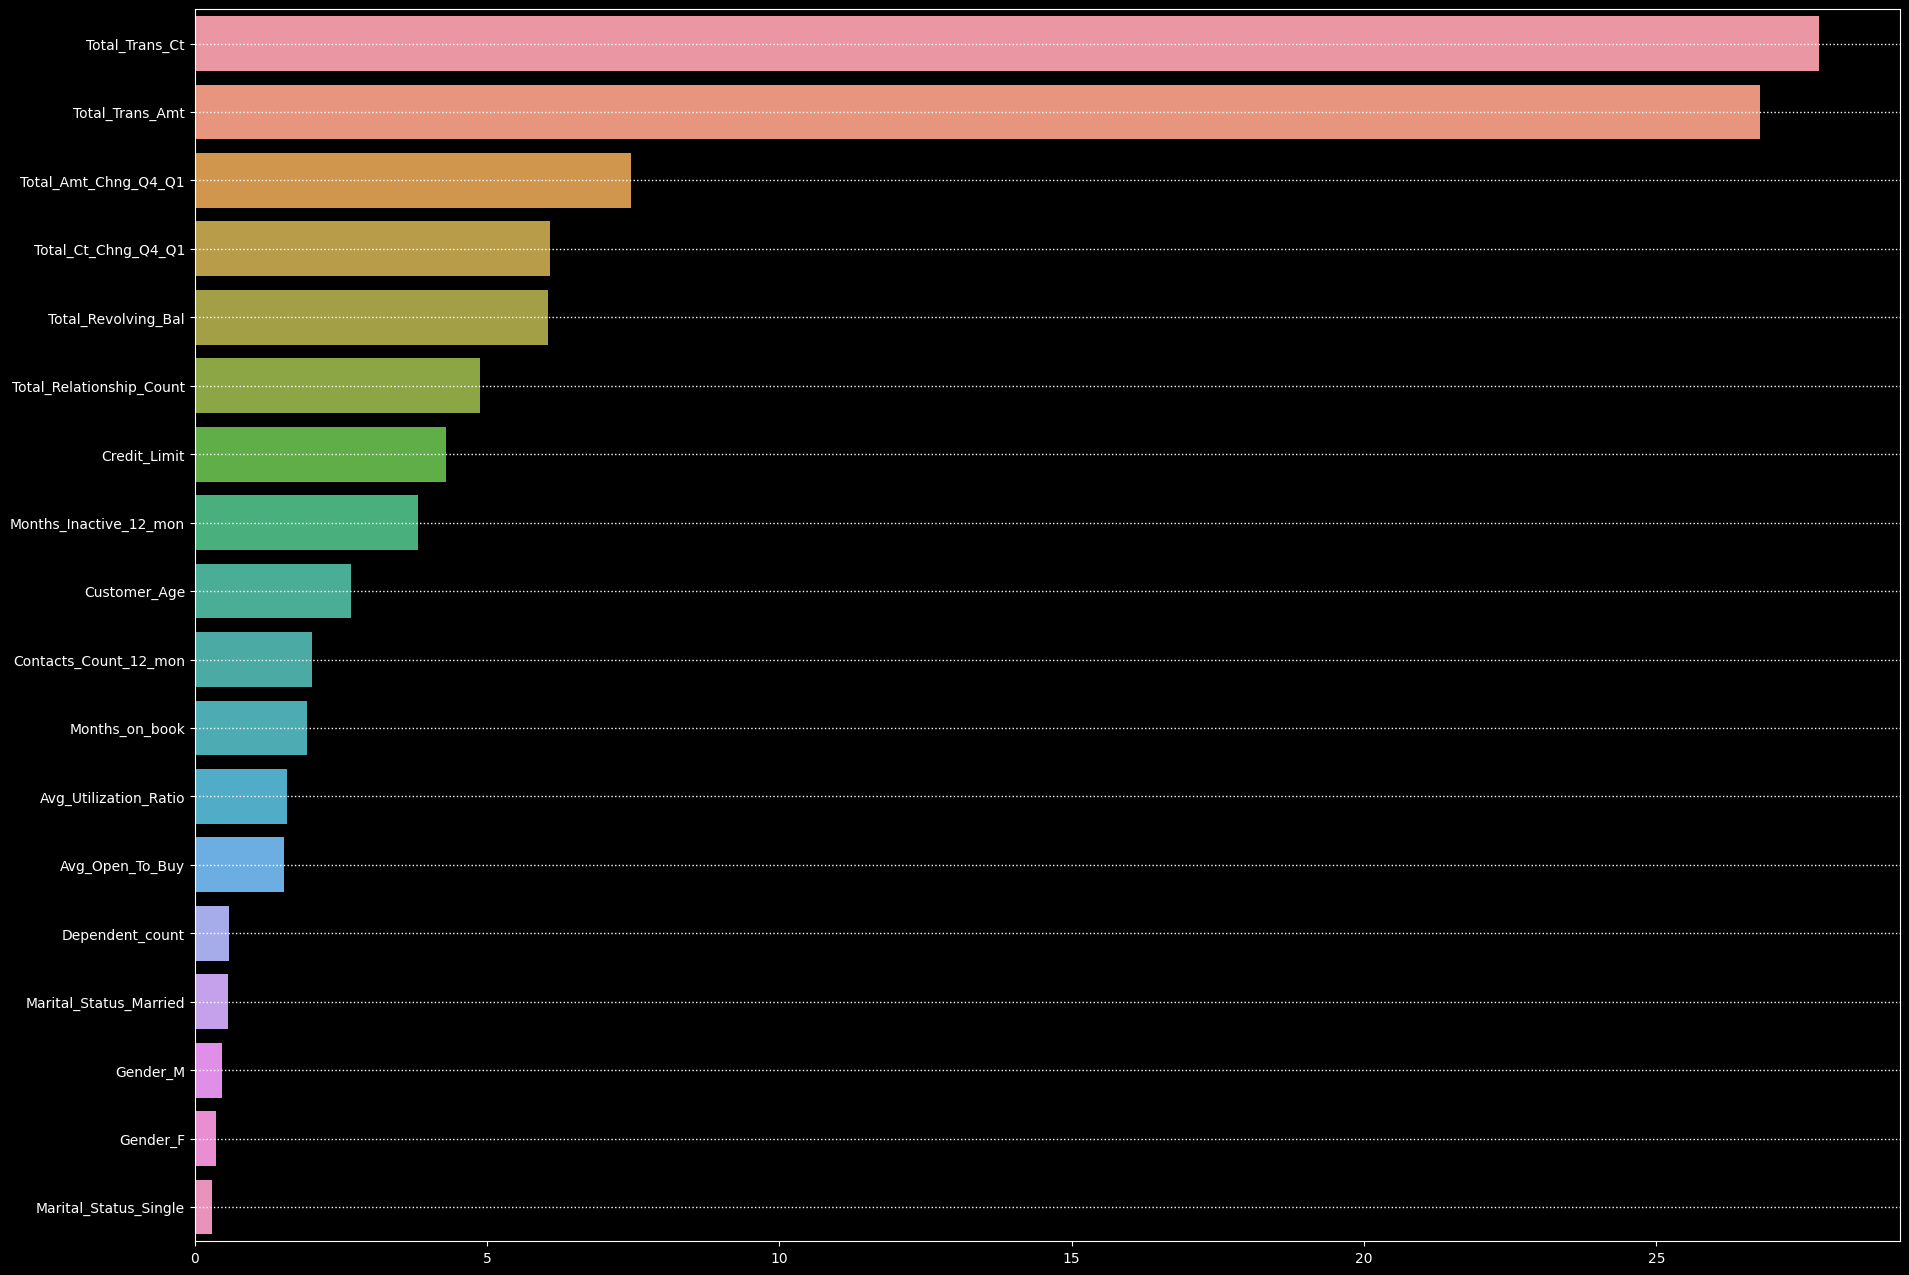

In [71]:
importances = importances.applymap(lambda x: x if x>=0.2980692275 else 0)
importances = importances.loc[:, (importances != 0).all(axis=0)]
plt.figure(figsize=(22,16))
sns.barplot(data=importances.sort_values(by=[0], axis=1, ascending=False), orient='h')
plt.grid(axis='y', color='white', linestyle='dotted', lw=1)
plt.show()

In [72]:
X_train1, X_test1 = X_train[importances.columns], X_test[importances.columns]

In [73]:
fitted_reduced_model1 = model.fit(X_train1, y_train)
y_pred1 = fitted_reduced_model1.predict(X_test1)

In [74]:
columns = ['Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Amt_Chng_Q4_Q1', 'Total_Revolving_Bal',
                            'Total_Relationship_Count', 'Total_Ct_Chng_Q4_Q1', 'Customer_Age', 'Months_Inactive_12_mon',
                            'Contacts_Count_12_mon', 'Credit_Limit']
X_train2, X_test2 = X_train[columns], X_test[columns]

In [75]:
fitted_reduced_model2 = model.fit(X_train2, y_train)
y_pred2 = fitted_reduced_model2.predict(X_test2)

In [76]:
print('Model 0: ', roc_auc_score(y_pred, y_test))
print('Model 1: ', roc_auc_score(y_pred1, y_test))
print('Model 2: ', roc_auc_score(y_pred2, y_test))

Model 0:  0.9703712216986553
Model 1:  0.9660689365441911
Model 2:  0.9702250158397131


Results are quite surprising, because model with the least explanatory variables (10) has really similar ROC AUC score as the most complex one (model 0 with 37 variables) and better score than reduced model (model 1 with 18 variables).  
Hence, model 2 should be choosed for further analysis.

In [77]:
#initializing explained for chosen model
model2_exp = dx.Explainer(fitted_reduced_model2, X_test2, y_test, label='CBC')

Preparation of a new explainer is initiated

  -> data              : 2532 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2532 values
  -> model_class       : catboost.core.CatBoostClassifier (default)
  -> label             : CBC
  -> predict function  : <function yhat_proba_default at 0x00000280CF6C5F30> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 2.19e-05, mean = 0.843, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         :  'residual_function' returns an Error when executed:
'float' object has no attribute 'astype'
  -> model_info        : package catboost

A new explainer has been created!


Checking residuals - there should be no pattern in residuals.  
Otherwise, it means that model is biased - it overestimates or underestimates predictions; so generally it means that explaining relations between data can be misleading.  

In [99]:
#residuals' plot
model_exp_diagnostic = model2_exp.model_diagnostics()
model_exp_diagnostic.plot(variable='ids', yvariable='residuals', show=False).update_layout(template='plotly_dark').show()
model_exp_diagnostic.plot(variable='y_hat', yvariable='residuals', show=False).update_layout(template='plotly_dark')

Second plot indices that the higher predicted value(y_hat) is, the smallest residuals are (more negative).  
It means, that model is better at predicting ones than zeros.

In [79]:
#print(precision_score(y_pred2, y_test))
#print(recall_score(y_pred2, y_test.values))

In [94]:
model_exp_PD = model2_exp.model_profile()
model_exp_PD.plot(show=False).update_layout(template='plotly_dark')

Calculating ceteris paribus: 100%|██████████| 10/10 [00:00<00:00, 19.88it/s]


In [81]:
single_datapoint = X_train2.sample(random_state=41)
#intercept should be also added to the model
#single_datapoint['intercept'] = 1
shap = model2_exp.predict_parts(single_datapoint, type = 'shap')

In [93]:
shap.plot(max_vars=20, show=False).update_layout(template='plotly_dark')

In [100]:
model_exp_bd = model2_exp.predict_parts(single_datapoint, type='break_down', order=np.array(['Total_Trans_Ct', 'Total_Trans_Amt', 'Total_Relationship_Count', 'Total_Revolving_Bal', 
                                                                                             'Total_Amt_Chng_Q4_Q1', 'Contacts_Count_12_mon', 'Credit_Limit', 'Customer_Age', 'Total_Ct_Chng_Q4_Q1',
                                                                                             'Months_Inactive_12_mon']))
model_exp_bd.plot(max_vars=20, show=False).update_layout(template='plotly_dark')

In [84]:
single_datapoint

,Total_Trans_Ct,Total_Trans_Amt,Total_Amt_Chng_Q4_Q1,Total_Revolving_Bal,Total_Relationship_Count,Total_Ct_Chng_Q4_Q1,Customer_Age,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit
7844,0.503876,0.270335,0.205181,0.465236,0.0,0.160474,0.319149,0.333333,0.166667,0.070975


In [85]:
y_train[7844]

1